Project submitted as a part of the IDC-409 Course,August 2024\
Submitted by Group 41\
Members :
- Sreedev M
- Nihal Ibrahim PP
- Munawar Ihsan VA

## Problem 
- Prepare an algorithm which can identify different objects in a
photo.
- Simple objects to be identified: Square, round, Triangle,
hexagonal, pentagonal


-----------

## Action Plan

Before going into the code, a brief action-plan/thought process for solving the problem is discussed here.

Our goal is to build an algorithm that can recognize shapes. The approach taken here is to use a Machine Learning model that can learn from data, feed it many many images of differnet shapes and use the "learned" model to recognize unseen images of shapes.

Since a ML Algorithm, would only learn to recognize vectors, we need some kind of representation technique, which can represent various shapes as vectors, while preserving their identities.
Once this is established, one can feed these vectors into the Model, and it should hopefully recognize unseen shape images.

One could also try employing different ML Algorithms for the job,and also compare their accuracies.

Let us begin.

The detailed description of the code-blocks are provided wherever necessary and the ideas/concepts are explained briefly.

In [1]:
# Importing required libraies

import cv2
import numpy as np
import os
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

## Contours

Contours can be explained simply as a curve joining all the continuous points (along the boundary), having same color or intensity. The contours are a useful tool for shape analysis and object detection and recognition.

OpenCV library is used to find contours.
In OpenCV, finding contours is like finding white object from black background.Object to be found should be white and background should be black.For better accuracy, binary images are used.


In [2]:
def contourfinder(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE) # reading image in b/w
    
    # converting img to binary with the threshold value determined by the otsu's method.
    threshold, img_bin = cv2.threshold(img, 0, 255, cv2.THRESH_OTSU|cv2.THRESH_BINARY_INV) 
    contours, hierarchy = cv2.findContours(img_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) # returns points of contour
    best_contour = max(contours, key=cv2.contourArea) # selecting the outermost contour
    return best_contour

## Chaincode

Chain codes are a method used to represent the contour of a shape in a compact form by encoding its boundary.
The contour is represented as a series of connected points, and each segment of the contour is encoded by a direction code, ranging from 0 to 7, indicating movement from one pixel to the next along the boundary.

The numbering system from 0 to 7 represents the 8 possible directions in which the contour can move between neighboring pixels in a 2D grid:

<img src="contourscheme.png" width="200" height="200">

For the contour of every image, a hisotgram is made, with each of these directions as bins. They would become the features of our vectors.

In [23]:
def chaincode_hist(img_path):

    best_contour = contourfinder(img_path)
    
    lookup_table = {
        (1, 0): 0,
        (1, -1): 1,
        (0, -1): 2,
        (-1, -1): 3,
        (-1, 0): 4,
        (-1, 1): 5,
        (0, 1): 6,
        (1, 1): 7
    }

    hist = np.zeros((16,))
    l = len(best_contour)-1
    for i in range(l):
        pt1 = best_contour[i][0]
        pt2 = best_contour[i+1][0]
        dx = pt2[0] - pt1[0]
        dy = pt2[1] - pt1[1]
        code = lookup_table[(dx, dy)]
        if i < l/2:
            hist[code] += 1
        else:
            hist[code + 8] += 1 # this is done just to increase the dimensionality for better predicitons

    return hist

In [4]:
# Creating a dataframe with paths to image files and their class labels

def data_df(data_path):
    
    class_dict = {
        'circle': 0,
        'square': 1,
        'star': 2,
        'triangle': 3,
        'pentagon' : 4,
        'hexagon' : 5
    }
    
    df = []
    
    for class_name, class_value in class_dict.items():
        class_folder = os.path.join(data_path, class_name)
        # for each image in class folder
        for file in os.listdir(class_folder):
            file_path = os.path.join(class_folder, file)
            if file_path.lower().endswith('.png'):
                df.append([file_path, class_value])
    
    df = pd.DataFrame(df, columns=['path', 'output'])
    
    return df

In [5]:
data = data_df("shapes")
data

,path,output
0,shapes\circle\0.png,0
1,shapes\circle\1.png,0
2,shapes\circle\10.png,0
3,shapes\circle\100.png,0
4,shapes\circle\1000.png,0
...,...,...
34846,shapes\hexagon\29995.png,5
34847,shapes\hexagon\29996.png,5
34848,shapes\hexagon\29997.png,5
34849,shapes\hexagon\29998.png,5


In [6]:
# Extracting chaincodes of each image and creating our X vector

def extract_features(img_paths): 
    n = len(img_paths)
    X = np.zeros((n, 16))
    for i in tqdm(range(n)):
        file_path = img_paths[i]
        features = chaincode_hist(file_path)
        X[i] = features
    return X

In [7]:
X = extract_features(data['path'])

100%|████████████████████████████████████████████████████████████████████████████| 34851/34851 [06:51<00:00, 84.68it/s]


In [8]:
Y = data['output']

In [9]:
# Splitting our data 75-25 so that we can train on 75%, and test how good our model is on the rest 25%.

from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.25, random_state=0
)

## SVC

A support vector machine constructs a hyper-plane or set of hyper-planes in a high or infinite dimensional space, which can be used for classification, regression or other tasks. Intuitively, a good separation is achieved by the hyper-plane that has the largest distance to the nearest training data points of any class (so-called functional margin), since in general the larger the margin the lower the generalization error of the classifier. The figure below shows the decision function for a linearly separable problem, with three samples on the margin boundaries, called “support vectors”.



In [10]:
from sklearn.svm import SVC

model = SVC()
model.fit(X_train, Y_train)


SVC()

## Metrics

Some metrics used to measure the accuracy and performance of the model are given below

- Accuracy Score : Measures the percentage of correct predictions out of the total predictions.
- Confusion Matrix : Displays the number of correct and incorrect predictions per class.
- Precision: The ratio of true positive predictions to the total predicted positives for a class.
- Recall: The ratio of true positive predictions to the total actual positives for a class.
- F1-Score: Harmonic mean of precision and recall; useful for imbalanced classes.
- Kohen's Kappa :Measures the agreement between predicted and actual classes, adjusting for chance. A higher Kappa score indicates better agreement
$$
\kappa=\frac{p_o-p_e}{1-p_e}
$$
- Matthews Correlation Coefficient (MCC):
$$
\mathrm{MCC}=\frac{T P \cdot T N-F P \cdot F N}{\sqrt{(T P+F P)(T P+F N)(T N+F P)(T N+F N)}}
$$


In [11]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import matthews_corrcoef

Y_pred_train = model.predict(X_train)
Y_pred_test = model.predict(X_test)

y_true = Y_test
y_pred = Y_pred_test

cm = confusion_matrix(y_true, y_pred)
report = classification_report(y_true, y_pred, zero_division=0) 
kappa = cohen_kappa_score(y_true, y_pred)
mcc = matthews_corrcoef(y_true, y_pred)

print("Training Accuracy = ",accuracy_score(Y_train, Y_pred_train))
print("Testing Accuracy = ",accuracy_score(Y_test, Y_pred_test))
print("Kohen's Cappa = ", kappa)
print("MCC = ", mcc)

Training Accuracy =  0.8312801285484734
Testing Accuracy =  0.8293354757259268
Kohen's Cappa =  0.7826452179101375
MCC =  0.8037587273774209


In [12]:
(print("Confusion Matrix"))
pd.DataFrame(cm)

Confusion Matrix


,0,1,2,3,4,5
0,905,0,0,0,0,0
1,16,842,0,0,0,100
2,0,0,906,0,0,0
3,6,1,0,888,0,0
4,0,5,0,0,2512,33
5,5,1,0,0,1320,1173


In [13]:
print(report)

              precision    recall  f1-score   support

           0       0.97      1.00      0.99       905
           1       0.99      0.88      0.93       958
           2       1.00      1.00      1.00       906
           3       1.00      0.99      1.00       895
           4       0.66      0.99      0.79      2550
           5       0.90      0.47      0.62      2499

    accuracy                           0.83      8713
   macro avg       0.92      0.89      0.89      8713
weighted avg       0.87      0.83      0.82      8713



In [14]:
# a function that takes an img path as input and guesses the shape
def test_model(model, img_path):
    classes = ['circle', 'square', 'star', 'triangle','pentagon','hexagon']
    x = chaincode_hist(img_path)
    c = model.predict([x])[0]
    return classes[c]


### General Input Test

Here a fucntion has been made that can scan an image and detect the various shapes present.\
The function would then call upon our model and output the name of various shapes.

**A test case is also shown with the shapes made in MS Paint**

In [15]:
def classifier(img_path,model):
    img = cv2.imread(img_path,cv2.IMREAD_GRAYSCALE)
    plt.imshow(img)
    plt.show()
    threshold, img_bin = cv2.threshold(img, 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)
    contours, hierarchy = cv2.findContours(img_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    print(f"No of identified shapes = {len(contours)}")
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        crop_img = img[y-50:y+h+50, x-50:x+w+50]
        cv2.imwrite("0.png",crop_img)
        path = "0.png"
        plt.imshow(crop_img,cmap = "gray")
        plt.title(test_model(model,path))
        os.remove("0.png")
        plt.show()

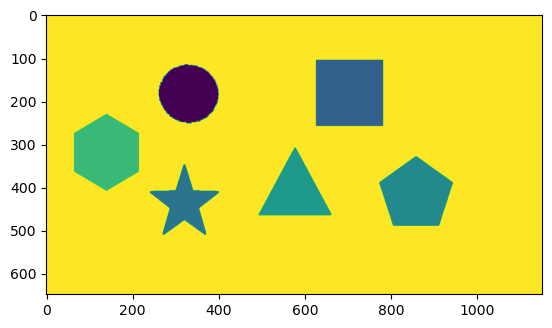

No of identified shapes = 6


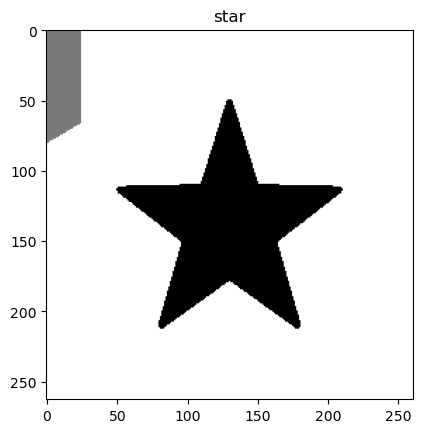

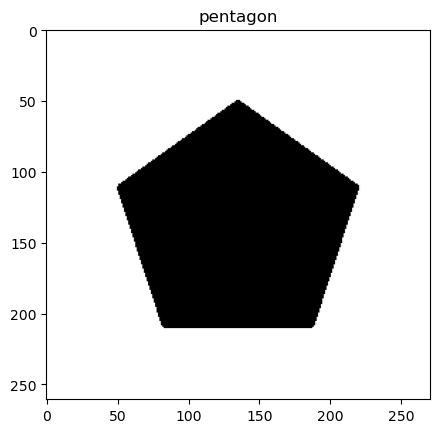

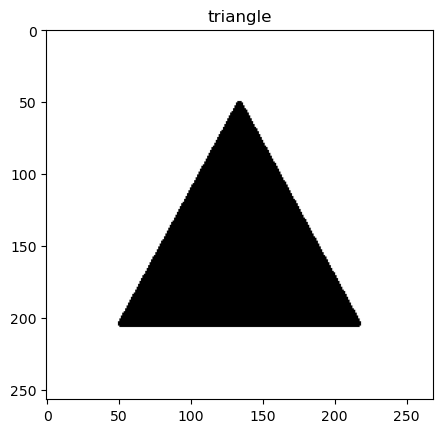

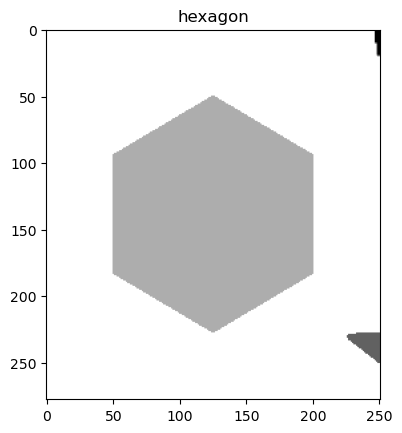

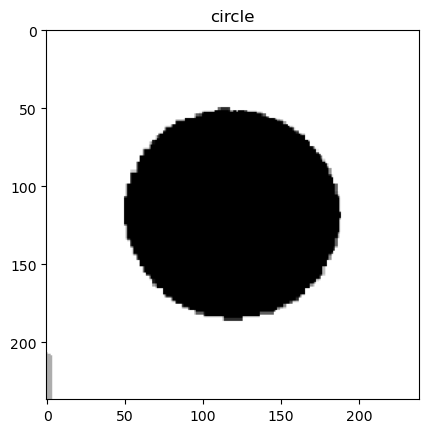

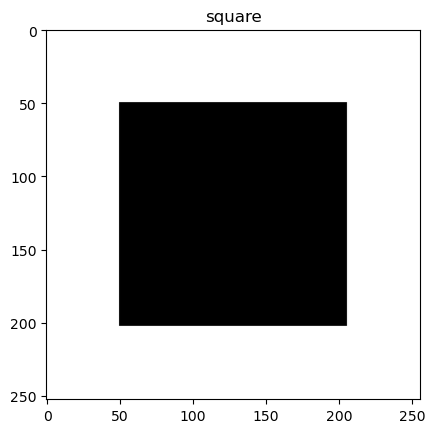

In [16]:
classifier("test.png",model)

## Random Forest Classifier
The Random Forest algorithm creates multiple decision trees during training. Each tree is trained on a different random subset of the training data.
When building each tree, Random Forest also selects a random subset of features at each split point. This random selection of features reduces correlation among trees, ensuring that each tree explores different patterns in the data.

When predicting, each decision tree in the forest produces its own class prediction.\
The final prediction is the class with the most votes among the trees.

In [17]:
from sklearn.ensemble import RandomForestClassifier

rfmodel = RandomForestClassifier()
rfmodel.fit(X_train,Y_train)

RandomForestClassifier()

In [18]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import matthews_corrcoef

Y_pred_train = rfmodel.predict(X_train)
Y_pred_test = rfmodel.predict(X_test)

y_true = Y_test
y_pred = Y_pred_test

cm = confusion_matrix(y_true, y_pred)
report = classification_report(y_true, y_pred, zero_division=0) 
kappa = cohen_kappa_score(y_true, y_pred)
mcc = matthews_corrcoef(y_true, y_pred)

print("Training Accuracy = ",accuracy_score(Y_train, Y_pred_train))
print("Testing Accuracy = ",accuracy_score(Y_test, Y_pred_test))
print("Kohen's Cappa = ", kappa)
print("MCC = ", mcc)

Training Accuracy =  0.8574106664626214
Testing Accuracy =  0.8571100654194881
Kohen's Cappa =  0.8184397070768995
MCC =  0.8402297736789083


In [19]:
(print("Confusion Matrix"))
pd.DataFrame(cm)

Confusion Matrix


,0,1,2,3,4,5
0,902,2,0,0,0,1
1,0,957,0,0,0,1
2,0,0,906,0,0,0
3,0,0,1,894,0,0
4,0,0,0,0,2549,1
5,0,2,0,0,1237,1260


In [20]:
print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       905
           1       1.00      1.00      1.00       958
           2       1.00      1.00      1.00       906
           3       1.00      1.00      1.00       895
           4       0.67      1.00      0.80      2550
           5       1.00      0.50      0.67      2499

    accuracy                           0.86      8713
   macro avg       0.94      0.92      0.91      8713
weighted avg       0.90      0.86      0.85      8713



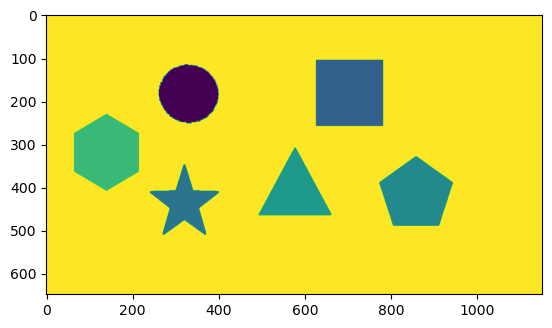

No of identified shapes = 6


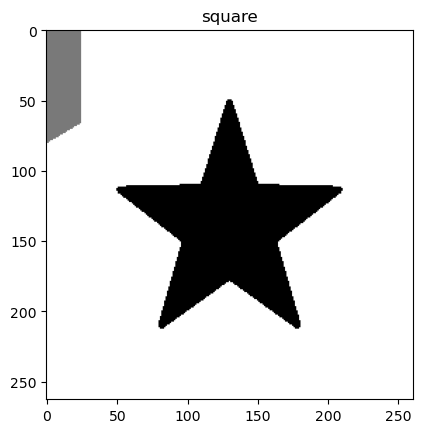

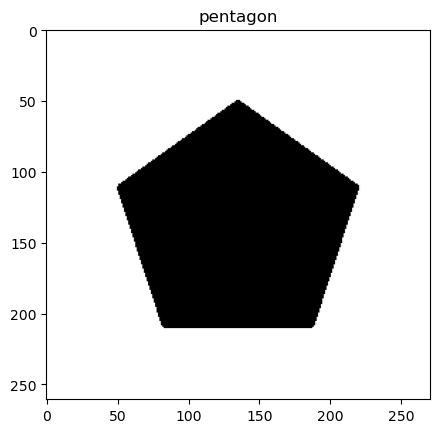

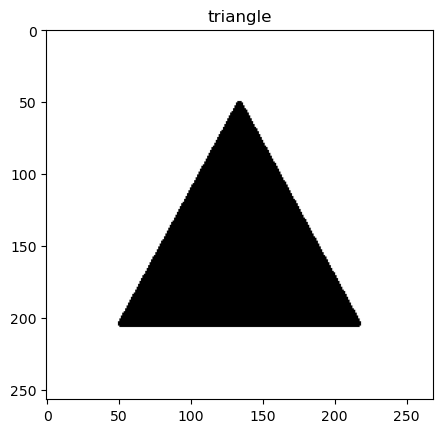

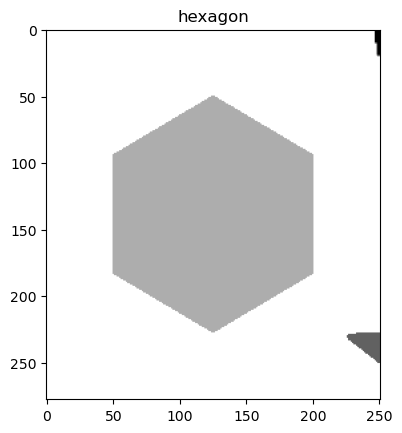

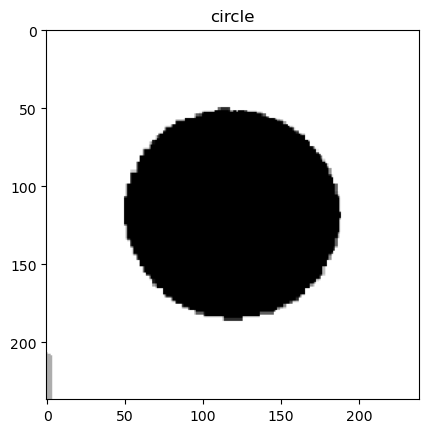

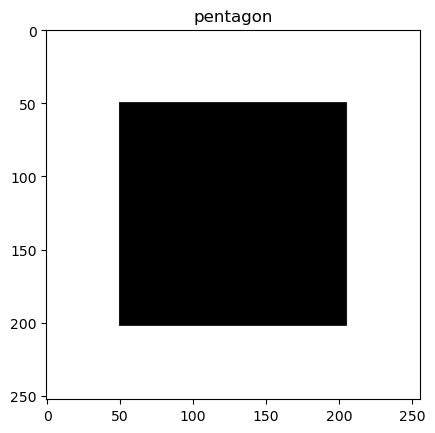

In [21]:
classifier("test.png",rfmodel)

In [22]:
# rf misidentified the square as a pentagon :(